In [112]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline

from scipy.special import gamma as Gamma
from scipy.stats import gamma, norm
from scipy.misc import logsumexp

In [91]:
n = 3
s = 15.
x1 = norm.rvs([0]*n, scale=[s]*n, size=(100000,n))
x2 = norm.rvs([0]*n, scale=[s]*n, size=(100000,n))
d12 = np.linalg.norm(x1 - x2, axis=1)

In [177]:
def pdf(x, s, n):
    V = (2*s**2)
    A = 2**(n/2-1) * V**(n/2) * Gamma(n/2)
    return x**(n-1) * np.exp(-x**2/(2*V)) / A

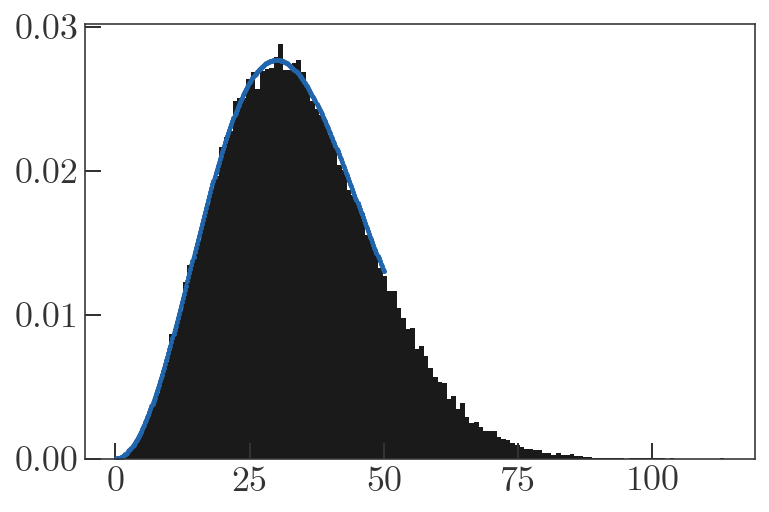

In [106]:
plt.hist(d12, bins='auto', normed=True);

_xs = np.linspace(0.1, 50, 256)
plt.plot(_xs, pdf(_xs, s, n))

---

### Generate simulated data

In [187]:
n_data = 400
qu_n_data = n_data//4
xyz1 = coord.CartesianRepresentation(100 * np.random.random(size=(3, n_data))*u.pc)

dx = coord.PhysicsSphericalRepresentation(r=np.random.random(n_data)*u.pc,
                                          phi=np.random.uniform(0,2*np.pi,n_data)*u.rad,
                                          theta=np.arccos(2*np.random.random(n_data) - 1)*u.rad)
xyz2 = xyz1 + dx

tmp = coord.PhysicsSphericalRepresentation(r=np.ones(n_data),
                                           phi=np.random.uniform(0,2*np.pi,n_data)*u.rad,
                                           theta=np.arccos(2*np.random.random(n_data) - 1)*u.rad)
tmp = tmp.represent_as(coord.CartesianRepresentation)
vxyz1 = np.random.normal(0, 30, n_data)*u.km/u.s * tmp.represent_as(coord.CartesianDifferential)
vxyz2 = vxyz1[np.concatenate((np.arange(qu_n_data), 
              qu_n_data+np.random.choice(3*qu_n_data, size=3*qu_n_data, replace=False)))]

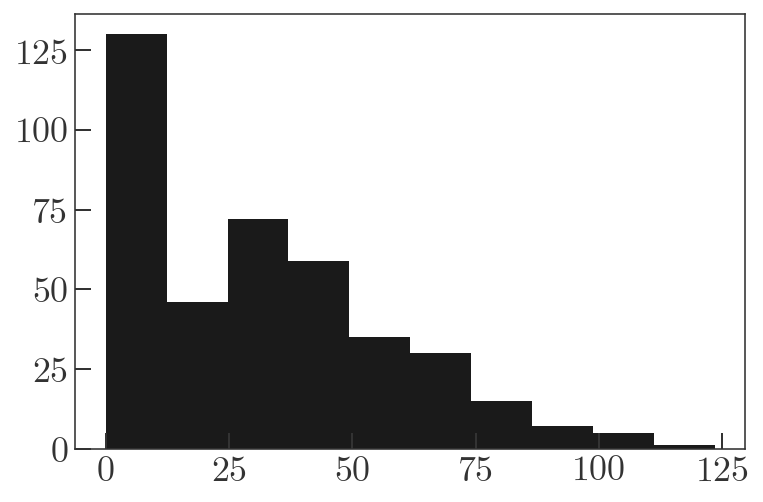

In [189]:
plt.hist((vxyz1 - vxyz2).norm(), bins='auto');

In [190]:
icrs1 = coord.ICRS(xyz1.with_differentials(vxyz1))
icrs2 = coord.ICRS(xyz2.with_differentials(vxyz2))

### Now we're going to "observe" the proper motions and radial velocity, but assume we know the distance

In [199]:
pm_err1 = np.random.uniform(0.2, 1., size=(n_data, 2)) # mas/yr
pm_err2 = np.random.uniform(0.2, 1., size=(n_data, 2))
rv_err1 = np.random.uniform(0.5, 1., size=n_data) # km/s
rv_err2 = np.random.uniform(0.5, 1., size=n_data)

pm1 = np.random.normal(np.stack((icrs1.pm_ra_cosdec.to(u.mas/u.yr).value,
                                 icrs1.pm_dec.to(u.mas/u.yr).value)).T,
                       pm_err1)
pm2 = np.random.normal(np.stack((icrs2.pm_ra_cosdec.to(u.mas/u.yr).value,
                                 icrs2.pm_dec.to(u.mas/u.yr).value)).T,
                       pm_err2)

rv1 = np.random.normal(icrs1.radial_velocity.to(u.km/u.s).value,
                       rv_err1)
rv2 = np.random.normal(icrs2.radial_velocity.to(u.km/u.s).value,
                       rv_err2)

In [200]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """
    ra = np.atleast_1d(ra)
    dec = np.atleast_1d(dec)
    s = []
    for cra, cdec in zip(ra, dec):
        s.append(
            np.array([
                [-np.sin(cra), np.cos(cra), 0.],
                [-np.sin(cdec)*np.cos(cra), -np.sin(cdec)*np.sin(cra), np.cos(cdec)],
                [np.cos(cdec)*np.cos(cra), np.cos(cdec)*np.sin(cra), np.sin(cdec)]
            ]))
    return np.array(s).squeeze()

In [201]:
fac = 1 / (1*u.km/u.s).to(u.pc*u.mas/u.yr, u.dimensionless_angles()).value

In [202]:
M1 = get_tangent_basis(icrs1.ra.radian, icrs1.dec.radian)
M2 = get_tangent_basis(icrs2.ra.radian, icrs2.dec.radian)

In [203]:
n_samples = 128
pm1_samples = np.random.normal(pm1, pm_err1, size=(n_samples, n_data, 2))
pm2_samples = np.random.normal(pm2, pm_err2, size=(n_samples, n_data, 2))
rv1_samples = np.random.normal(rv1, rv_err1, size=(n_samples, n_data))
rv2_samples = np.random.normal(rv2, rv_err2, size=(n_samples, n_data))

v1_samples = np.array([icrs1.distance.value[None] * pm1_samples[...,0] * fac, 
                       icrs1.distance.value[None] * pm1_samples[...,1] * fac,
                       rv1_samples])

v2_samples = np.array([icrs2.distance.value[None] * pm2_samples[...,0] * fac, 
                       icrs2.distance.value[None] * pm2_samples[...,1] * fac,
                       rv2_samples])

v1_samples = np.einsum('nij,ikn->jkn', M1, v1_samples)
v2_samples = np.einsum('nij,ikn->jkn', M2, v2_samples)
dv_samples = np.linalg.norm(v1_samples - v2_samples, axis=0)
dv_samples.shape

(128, 400)

In [209]:
def ln_dv_pdf(x, sigma):
    return 2*np.log(x) - x**2/(4*sigma**2) - 1.2655121234846456 - 3*np.log(sigma)

def ln_likelihood(p):
    f = p[0]
    b = np.vstack((np.full(n_samples, f), np.full(n_samples, 1-f)))
    
    term1 = ln_dv_pdf(dv_samples, 0.1)
    term2 = ln_dv_pdf(dv_samples, 30.)

    ll = np.zeros(term1.shape[1])
    for n in range(n_data):
        ll[n] += logsumexp([term1[:,n], term2[:,n]], b=b) - np.log(n_samples)
    
    return ll

In [210]:
lls = []
fs = np.linspace(0, 1, 128)

for f in fs:
    lls.append(ln_likelihood([f]).sum())
    
lls = np.array(lls)
plt.plot(fs, np.exp(lls - lls.max()))

### Now we'll assume we have noisy parallax measurements:

In [224]:
v1_samples_tmp = np.array([pm1_samples[...,0] * fac, 
                           pm1_samples[...,1] * fac,
                           rv1_samples])

v2_samples_tmp = np.array([pm2_samples[...,0] * fac, 
                           pm2_samples[...,1] * fac,
                           rv2_samples])

def get_dv_samples(d1, d2):
    d1_tmp = np.vstack((d1, d1, np.ones_like(d1)))
    d2_tmp = np.vstack((d2, d2, np.ones_like(d2)))
    v1_samples = np.einsum('nij,ikn->jkn', M1, v1_samples_tmp * d1_tmp[:,None,:])
    v2_samples = np.einsum('nij,ikn->jkn', M2, v2_samples_tmp * d2_tmp[:,None,:])
    return np.linalg.norm(v1_samples - v2_samples, axis=0)

In [217]:
plx1 = icrs1.distance.to(u.mas, u.parallax()).value
plx2 = icrs1.distance.to(u.mas, u.parallax()).value

plx1_err = np.full(n_data, 0.3)
plx2_err = np.full(n_data, 0.3)
plx1 = np.random.normal(plx1, plx1_err)
plx2 = np.random.normal(plx2, plx2_err)

In [304]:
n_dgrid = 5
d1_min, d1_max = 1000 / (plx1 + 3*plx1_err), 1000 / (plx1 - 3*plx1_err)
d2_min, d2_max = 1000 / (plx2 + 3*plx2_err), 1000 / (plx2 - 3*plx2_err)

d1_grids = np.array([np.linspace(d1_min[i], d1_max[i], n_dgrid) for i in range(n_data)])
d2_grids = np.array([np.linspace(d2_min[i], d2_max[i], n_dgrid) for i in range(n_data)])

In [305]:
from scipy.integrate import simps

In [310]:
def ln_likelihood_at_d1d2(p, d1, d2):
    f = p[0]
    b = np.vstack((np.full(n_samples, f), np.full(n_samples, 1-f)))
    
    dv_samples = get_dv_samples(d1, d2)
    term1 = ln_dv_pdf(dv_samples, 0.1)
    term2 = ln_dv_pdf(dv_samples, 30.)

    ll = np.zeros(term1.shape[1])
    for n in range(n_data):
        ll[n] += logsumexp([term1[:,n], term2[:,n]], b=b) - np.log(n_samples)
    
    return ll

def ln_likelihood_with_dist(p):
    ll_grid = np.zeros((n_data, n_dgrid, n_dgrid))
    for i in range(n_dgrid):
        for j in range(n_dgrid):
            ll_grid[:,i,j] = (ln_likelihood_at_d1d2(p, d1_grids[:,i], d2_grids[:,j]) + 
                              norm.logpdf(1000/d1_grids[:,i], plx1, plx1_err) +
                              norm.logpdf(1000/d2_grids[:,j], plx2, plx2_err))
    
    l_grid = np.exp(ll_grid)
    likes = np.array([simps(simps(l_grid[n], d2_grids[n]), d1_grids[n]) for n in range(n_data)])
    return np.log(likes)

In [311]:
%time ll_grid = ln_likelihood_with_dist([0.25])

CPU times: user 1.29 s, sys: 11.7 ms, total: 1.31 s
Wall time: 1.32 s


In [313]:
lls = []
fs = np.linspace(0, 0.5, 32)

for f in fs:
    lls.append(ln_likelihood_with_dist([f]).sum())

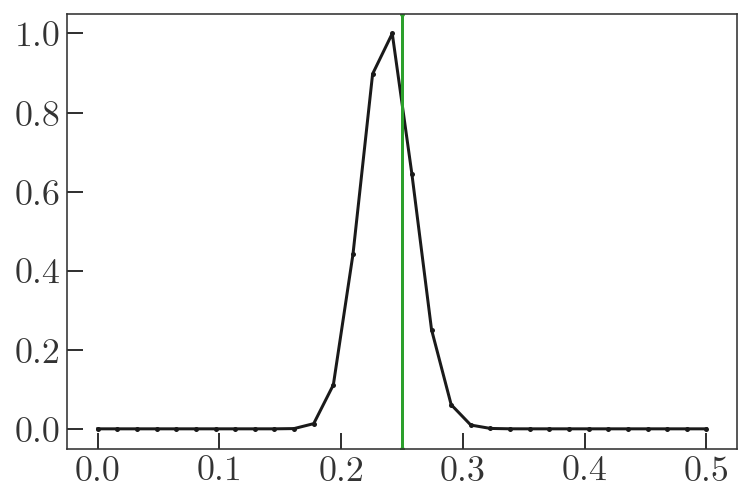

In [315]:
lls = np.array(lls)
plt.plot(fs, np.exp(lls - lls.max()))
plt.axvline(0.25, color='tab:green') # truth 